# A New Death Graph for GA-DPH

Dear Georgia DPH, 

Please feel free to take what you need. 

P.S. Please stop using pie-charts.

### Imports

In [1]:
# the usual imports - all you need if you have the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
# selenium scraping - getting the data from dph.georgia.gov
import os
from selenium import webdriver

---

### Scraping

In [2]:
# spin up selenium and start on our target page

chromedriver = "/Applications/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver

url = 'https://dph.georgia.gov/covid-19-daily-status-report'
driver = webdriver.Chrome(chromedriver)
driver.get(url)

In [3]:
# data is hidden beneath an iframe

iframe = driver.find_element_by_xpath('//*[@id="covid19dashdph"]/iframe')

driver.switch_to.frame(iframe)

In [4]:
# go to "deaths" table and gather all rows, save in rows

table_trs = driver.find_elements_by_xpath('//*[@id="deaths"]/table/tbody/tr')
rows = []
for tr in table_trs:
    td = tr.find_elements_by_xpath(".//td")
    rows.append([i.text for i in td])
    
driver.close()

In [5]:
# row 0 are headers, 1 to end are data

data = pd.DataFrame(data=rows[1:], columns=rows[0])

### Post-scrape

Start here if you already have the data.

If the data is in a csv or excel file then you can read it in with the following (remember to change the path):

csv: data = pd.read_csv('path_to_data.csv')

excel: data = pd.read_excel('path_to_data.xlsx')

In [6]:
# quick workaround: age can be str(age) or "unk"

age = []
for i in data['Age']:
    try:
        age.append(int(i))
    except:
        age.append(np.nan)
data['Age'] = age

In [7]:
# setup bins based on max age (no manual adjusting in the future)

bins = np.arange(0, (math.ceil(max(data['Age'])/10)*10)+11, 10)

bins  # bins are 0-9, 10-19, etc.

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110])

In [8]:
# cut age based on bins

data['age_bins'] = pd.cut(data['Age'], bins=bins, right=False)

# groupby age + underlying conditions

categories = data.groupby(['age_bins', 'Underlying'])['Age'].count().unstack().fillna(0)

categories.index = [i.mid for i in categories.index]  # use midpoints for idx

categories

Underlying,No,Unk,Yes
25.0,2.0,1.0,1.0
35.0,1.0,3.0,7.0
45.0,0.0,2.0,17.0
55.0,3.0,12.0,25.0
65.0,3.0,32.0,79.0
75.0,1.0,24.0,91.0
85.0,4.0,40.0,72.0
95.0,1.0,14.0,27.0
105.0,0.0,1.0,0.0


### Pretty Picture

Matplotlib is nice because all of the paramaters can be tweaked manually, and descriptions are straightforward. i.e. color means color, hist means histogram, title means title, etc.

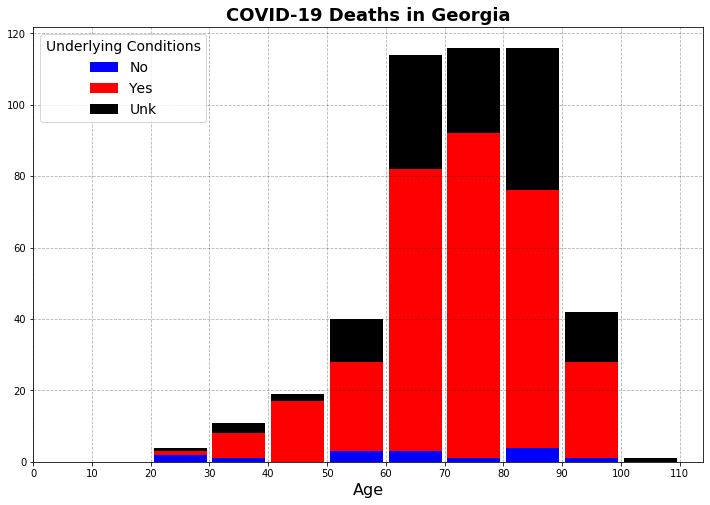

In [9]:
# stacked bar plot with all the bells and whistles

plt.figure(figsize=(12, 8))

plt.title('COVID-19 Deaths in Georgia',
          fontsize=18,
          fontweight='bold')
plt.xlabel('Age',
           fontsize=16)

plt.bar(categories.index,
        categories['No'],
        width=9,
        color='b',
        label='No')
plt.bar(categories.index,
        categories['Yes'],
        width=9,
        color='r',
        label='Yes',
        bottom=categories['No'].values)
plt.bar(categories.index,
        categories['Unk'],
        width=9,
        color='k',
        label='Unk',
        bottom=categories['No'].values+categories['Yes'].values)

plt.xticks(bins)

plt.legend(fontsize=14,
           loc='upper left',
           title='Underlying Conditions',
           title_fontsize='14')

plt.grid(alpha=0.3,
         color='k',
         linestyle='--');

# plt.savefig('covid-age.png')   # optional save-off

### Bonus, scraping FIPS

In [15]:
# fips url

url = 'https://www.nrcs.usda.gov/wps/portal/nrcs/detail/ga/home/?cid=nrcs143_013697'

driver = webdriver.Chrome(chromedriver)

driver.get(url)

In [22]:
# this is a large table, but good to have if you ever want to build a map viz

table_trs = driver.find_elements_by_xpath('//*[@id="detail"]/table/tbody/tr')
rows = []
for tr in table_trs:
    td = tr.find_elements_by_xpath(".//td")
    rows.append([i.text for i in td])
    
driver.close()

In [37]:
# save this off for later

pd.DataFrame(data=rows[1:], columns=['FIPS', 'County', 'State']).to_csv('fips_codes.csv')

In [37]:
# filter for GA fips

fips = pd.DataFrame(data=[i for i in rows[1:] if i[2] == 'GA'], columns=['FIPS', 'County', 'State'])

In [32]:
# merge on deaths data and save

merge_data = data.copy()
merge_data['County'] = [i.lower() for i in merge_data['County']]
fips['County'] = [i.lower() for i in fips['County']]

pd.merge(merge_data, fips, how='left', left_on='County', right_on='County').to_csv('covid_GA_deaths.csv')